# Live COVID-19 ('Novel Coronavirus') Data Inspector
*Copyright (c) 2020 [@shaunakg](https://github.com/shaunakg/)* and **licensed under the MIT License**

Loading database from website... Done.
Organising data... Done.
Writing to file... Done.


 --- COVID-19 Live Data Inspection Tool ---
Enter city name (use proper capitalisation) : Wuhan
Display records going back this many entries: 200
WARN: Too many data points to make pie charts
Confirmed coronavirus cases in Wuhan, Hubei:
2020-02-18 19:02:17.294000+08:00 - 42752 confirmed, 1381 deceased and 4253 cured.
2020-02-18 18:46:52.264000+08:00 - 42752 confirmed, 1381 deceased and 4253 cured.
2020-02-18 14:14:26.622000+08:00 - 42752 confirmed, 1381 deceased and 4229 cured.
2020-02-18 13:05:31.571000+08:00 - 42752 confirmed, 1381 deceased and 4221 cured.
2020-02-18 11:44:23.488000+08:00 - 42752 confirmed, 1381 deceased and 4221 cured.
2020-02-18 11:40:17.098000+08:00 - 42752 confirmed, 1381 deceased and 4219 cured.
2020-02-18 11:17:41.140000+08:00 - 42752 confirmed, 1381 deceased and 4219 cured.
2020-02-18 07:13:10.209000+08:00 - 42752 confirmed, 1381 deceased and 4219 cured.
2020-02-17 20:22

Generating line plot for your datapoints... Done.


- DATA SOURCE: Data from ncov.dxy.cn/ncovh5/view/pneumonia via github.com/BlankerL/DXY-COVID-19-Data
- All times are in UTC+0800 - China Standard Time unless otherwise stated.
- Current data last updated at 2020-01-27 07:15:04.158000+08:00


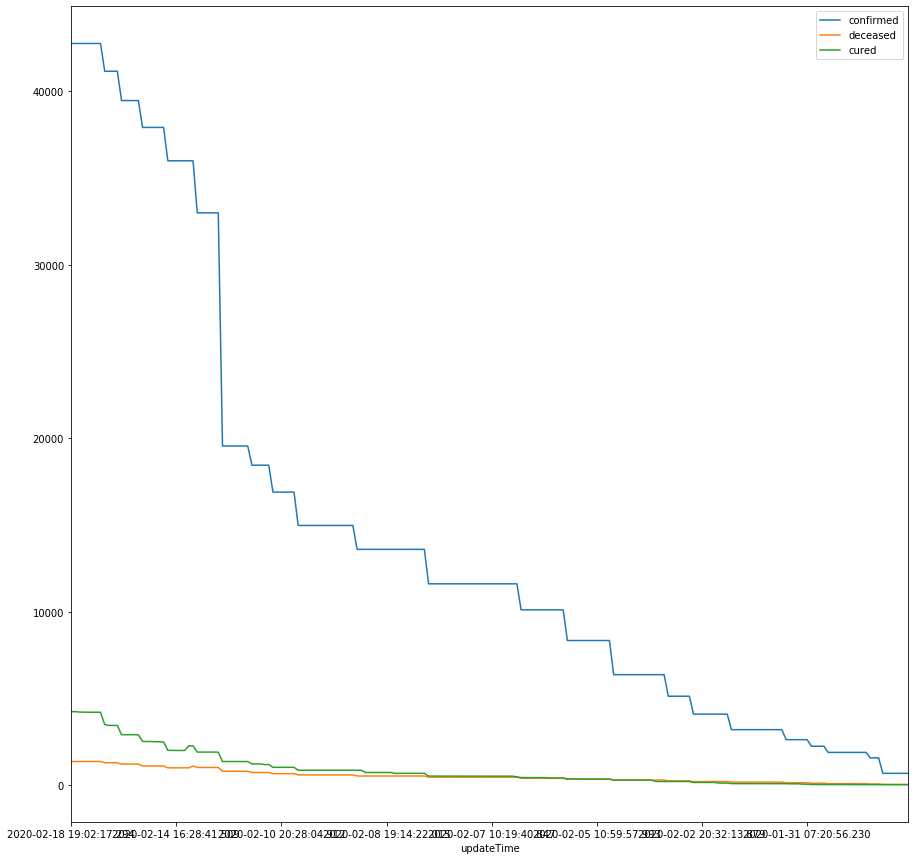

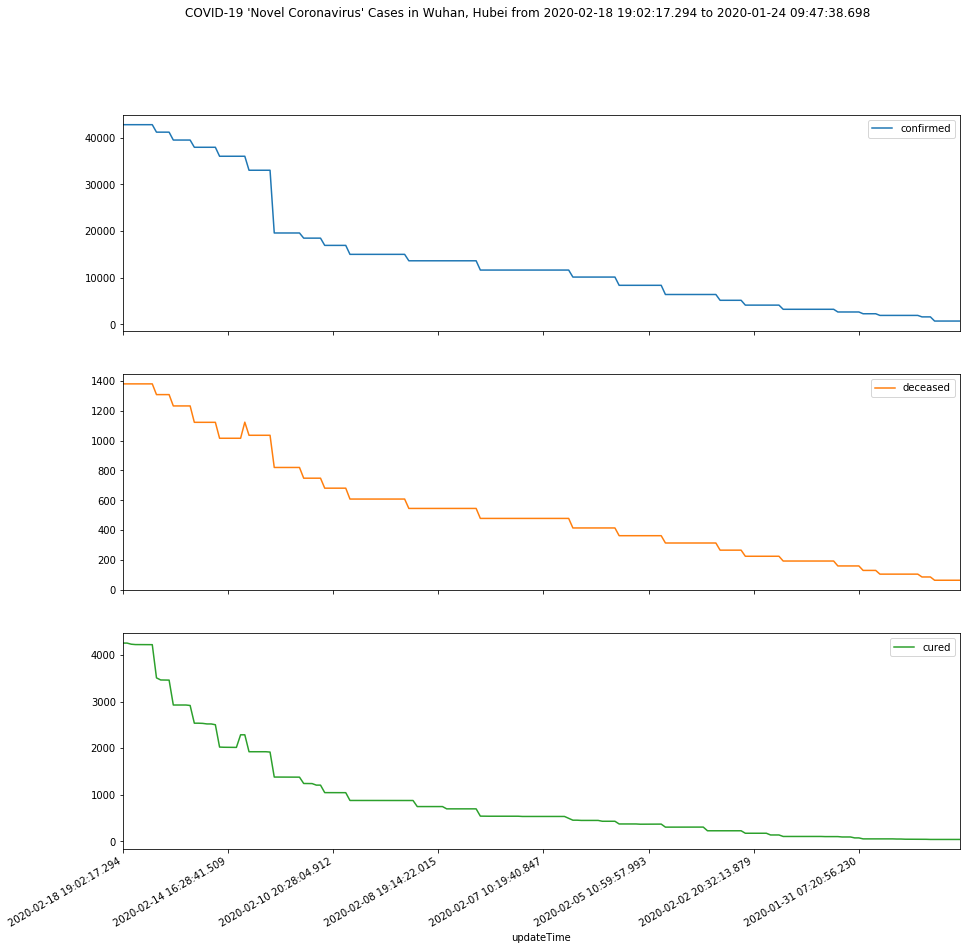

In [7]:
# Live COVID-19 ('Novel Coronavirus') data display
# Copyright (c) 2020 @shaunakg under the MIT License

# This required features from Python 3.7 - please check your python version before running this notebook

# DON'T EXPORT THIS JUPYTER NOTEBOOK: THE DATA WILL NO LONGER BE UPDATED

# If you installed Jupyter via Anaconda then you should have pandas, pytz etc - otherwise run 'pip install pandas pytz'
import pandas as pd 
from datetime import datetime
import pytz

print('Loading database from website...', end="")

# Get data from live github repository https://github.com/BlankerL/DXY-COVID-19-Data/
try:
    all_data = pd.read_csv('https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv');
except:
    print("\nERROR - Unable to download recent data. Using previous data... ", end='')
    
    try:
        all_data = pd.read_csv('__live_merged_data.csv')
    except:
        print("\nWARN: Using sample dataset - please run online for updated information! Loading...", end="")
        all_data = pd.read_csv('__sample_data.csv')

print(" Done.")
print('Organising data...', end="")

# Data is a merge of city and province information, seperate them
province_data = all_data[['provinceEnglishName','province_zipCode','province_confirmedCount','province_suspectedCount','province_curedCount','province_deadCount','updateTime']].copy().drop_duplicates()
city_data = all_data[['provinceEnglishName','cityEnglishName','city_zipCode','city_confirmedCount','city_suspectedCount','city_curedCount','city_deadCount','updateTime']].drop_duplicates()

print(" Done.")
print('Writing to file...', end="")

# Write data to files
all_data.to_csv('__live_merged_data.csv', index=False, mode="w+");
province_data.to_csv('__live_province_data.csv', index=False, mode="w+")
city_data.to_csv('__live_city_data.csv', index=False, mode="w+")

print(" Done.\n\n\n --- COVID-19 Live Data Inspection Tool ---")
location_query_result = []

while len(location_query_result) == 0:

    # Still haven't figured out how to not match case
    input_city = input("Enter city name (use proper capitalisation) : ")
    location_query_result = city_data.loc[city_data['cityEnglishName'] == input_city]
    if len(location_query_result) == 0:   
        # There aren't any rows in the result
        print(f'No novel coronavirus cases reported for "{ input_city }". (Capitalisation DOES matter)')
    else:
        break    
    
# Sort by update time
location_query_result.sort_values(by=['updateTime'], ascending=False)

# Ask how many rows to display data on
num_reports = int(input("Display records going back this many entries: "))

starting_update_time = location_query_result['updateTime'].iloc[-1]
ending_update_time = location_query_result['updateTime'].iloc[0]

if (num_reports >= 20):
    print("WARN: Too many data points to make pie charts")

city_province = location_query_result['provinceEnglishName'].iloc[0]
print(f"Confirmed coronavirus cases in { input_city }, { city_province }:")

for i in range(num_reports):

    confirmedCases = location_query_result['city_confirmedCount'].iloc[i]
    deadCases = location_query_result['city_deadCount'].iloc[i]
    curedCases = location_query_result['city_curedCount'].iloc[i]

    update_time_obj = pytz.timezone('Asia/Shanghai').localize(datetime.strptime(location_query_result['updateTime'].iloc[i] + "000", "%Y-%m-%d %H:%M:%S.%f"))

    print(f"{ update_time_obj } - { confirmedCases } confirmed, { deadCases } deceased and { curedCases } cured. { previous_update_time_obj - update_time_obj } ")

    if (num_reports < 20):        
        city_newest_row = pd.DataFrame({'cases': [confirmedCases, deadCases, curedCases]}, index=['Confirmed Cases', 'Deceased', 'Cured'])
        pie_plot = city_newest_row.plot.pie(y='cases', figsize=(7, 7), title=f"COVID-19 'Novel Coronavirus' Cases in { input_city }, { city_province } as of { update_time_obj }")
        
    prev_update_time_obj = update_time_obj

if (num_reports > 1):

    print("Generating line plot for your datapoints...", end="")

    line_frame = pd.DataFrame({
            'confirmed': location_query_result['city_confirmedCount'].iloc[0:num_reports].tolist(),
            'deceased': location_query_result['city_deadCount'].iloc[0:num_reports].tolist(),
            'cured': location_query_result['city_curedCount'].iloc[0:num_reports].tolist()
    }, index=location_query_result['updateTime'].iloc[0:num_reports])

    line_allplots = line_frame.plot.line(figsize=(15,15))
    line_subplots = line_frame.plot.line(subplots=True, figsize=(15,15), title=f"COVID-19 'Novel Coronavirus' Cases in { input_city }, { city_province } from { starting_update_time } to { ending_update_time }")

    print(" Done.")

print("\n\n- DATA SOURCE: Data from ncov.dxy.cn/ncovh5/view/pneumonia via github.com/BlankerL/DXY-COVID-19-Data")    
print("- All times are in UTC+0800 - China Standard Time unless otherwise stated.")
print(f"- Current data last updated at { update_time_obj }")
